### Given the Data, the goal is to predict whether a person has diabetes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score,recall_score,f1_score

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("diabetes.csv")

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.shape

(768, 9)

In [6]:
# To check how many of each class are there
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [7]:
# To check information of our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


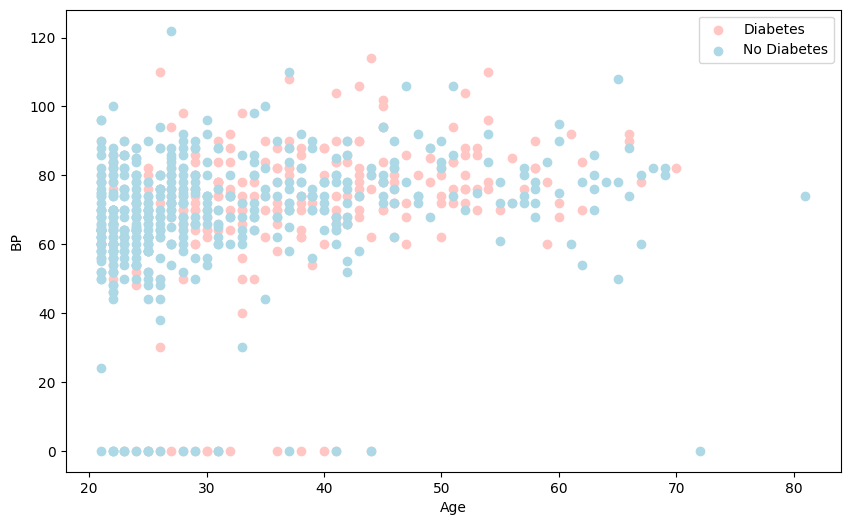

In [10]:
# Comparing Age vs Blood Pressure
plt.figure(figsize=(10,6))
plt.scatter(df.Age[df["Outcome"]==1],
           df.BloodPressure[df["Outcome"]==1],
           c="#ffc6c4")
plt.xlabel("Age")
plt.ylabel("BP")

plt.scatter(df.Age[df["Outcome"]==0],
           df.BloodPressure[df["Outcome"]==0],
           c="Lightblue")

plt.legend(["Diabetes","No Diabetes"]);

In [11]:
df.BloodPressure[df.Outcome==1].head(30)

0      72
2      64
4      40
6      50
8      70
9      96
11     74
13     60
14     72
15      0
16     84
17     74
19     70
22     90
23     80
24     94
25     70
26     76
31     76
37     76
38     68
39     72
43    110
45     66
48     66
53     90
56     68
61     72
64     66
66     88
Name: BloodPressure, dtype: int64

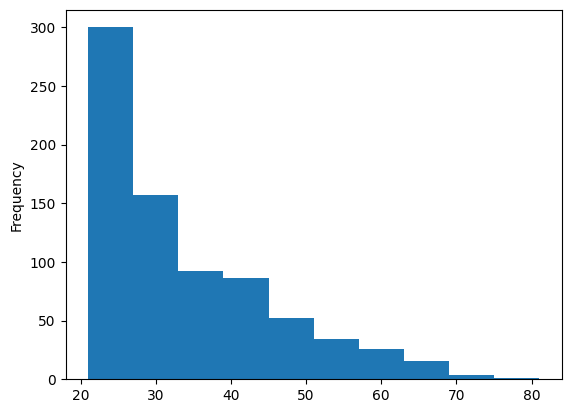

In [12]:
df.Age.plot.hist();

In [13]:
df.groupby("Outcome").mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [14]:
df[df.BloodPressure==0].shape[0],df[df.Glucose==0].shape[0]

(35, 5)

In [15]:
df[df.SkinThickness==0].shape[0],df[df.BMI==0].shape[0],df[df.Insulin==0].shape[0]

(227, 11, 374)

In [16]:
print(df[df.Glucose == 0].groupby('Outcome')['Age'].count())

Outcome
0    3
1    2
Name: Age, dtype: int64


#### As we can see, the above data contains certain inconsistency as there are 35,5,227,11,374 cases where blood pressure,glucose,skin thickness,BMI,Insulin is 0 respectively. We can use following method to remove them

* Put avreage/mean values: Can work for predicting price of a location as it remains constant throughout, but cannot use the same here since we will be feeding wrong data to our model (Glucose doesnt remain the same for everyone).
* Ignore/remove these cases: This is not actually possible in most cases because that would mean losing valuable information. And in this case “skin thickness” and “insulin” columns mean to have a lot of invalid points. But it might work for “BMI”, “glucose ”and “blood pressure” data points.

In [17]:
# Removing the rows of BMI, BP, Glucose where value is 0
df1 = df[(df.BloodPressure != 0) & (df.BMI != 0) & (df.Glucose != 0)]

In [18]:
df1.shape

(724, 9)

### Feature Engineering

Since all the features of `Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age` are important for determining diabetes, we will not eliminate any features

In [19]:
df1.corr()  # Shows how the columns are correlated

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.134915,0.209668,-0.095683,-0.080059,0.012342,-0.025996,0.557066,0.224417
Glucose,0.134915,1.000000,0.223331,0.074381,0.337896,0.223276,0.136630,0.263560,0.488384
BloodPressure,0.209668,0.223331,1.000000,0.011777,-0.046856,0.287403,-0.000075,0.324897,0.166703
SkinThickness,-0.095683,0.074381,0.011777,1.000000,0.420874,0.401528,0.176253,-0.128908,0.092030
Insulin,-0.080059,0.337896,-0.046856,0.420874,1.000000,0.191831,0.182656,-0.049412,0.145488
BMI,0.012342,0.223276,0.287403,0.401528,0.191831,1.000000,0.154858,0.020835,0.299375
DiabetesPedigreeFunction,-0.025996,0.136630,-0.000075,0.176253,0.182656,0.154858,1.000000,0.023098,0.184947
Age,0.557066,0.263560,0.324897,-0.128908,-0.049412,0.020835,0.023098,1.000000,0.245741
Outcome,0.224417,0.488384,0.166703,0.092030,0.145488,0.299375,0.184947,0.245741,1.000000


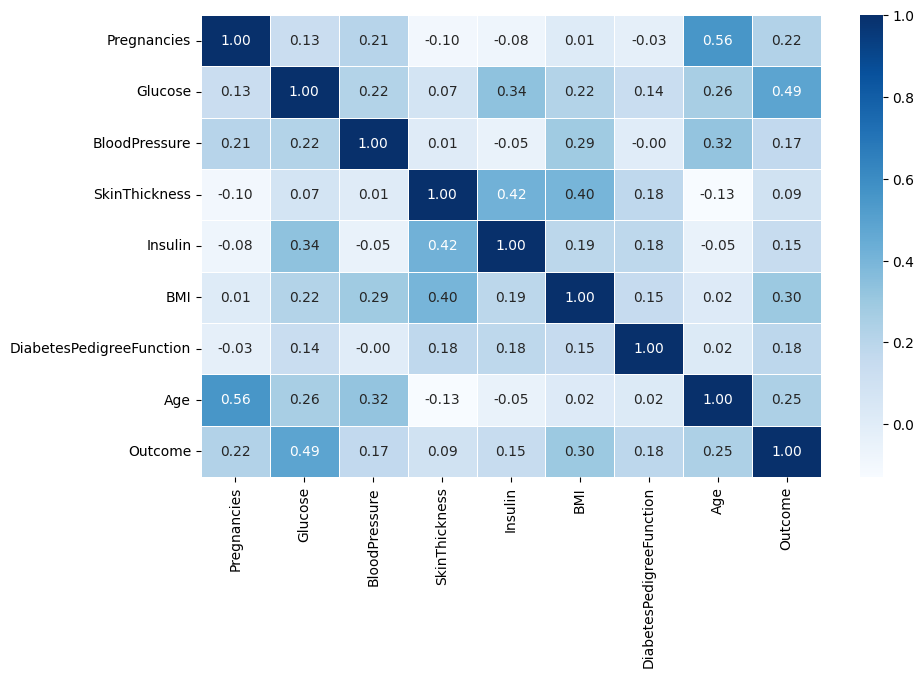

In [20]:
# Visualizing using seaborn

corr_matrix = df1.corr()

fig,ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(corr_matrix,
                linewidths=0.5,
                fmt='.2f',
                annot=True,
                cmap="Blues");

The above graph shows how the features are correlated to each other. The value pf glucose mapped to Outcome is 0.49 i.e if the glucose level goes high the chances of being diabetic goes high as well (indicates direct proportionality). Negative values shows indirect proportionality(the outcome isn't indirectly proportional to any features in our case).

In [21]:
x = df.drop("Outcome",axis=1)
y = df["Outcome"]

In [22]:
x.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [23]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [24]:
np.random.seed(1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=2)

In [25]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [26]:
models = {"Logistic Regression":LogisticRegression(),
          "KNN":KNeighborsClassifier(),
          "Random Forest":RandomForestClassifier(),
          "SVC":SVC(),
          "GNB":GaussianNB(),
          "Decision Tree":DecisionTreeClassifier(max_depth=10,min_samples_leaf=15,random_state=2)}

def fit_and_score(models,x_train,x_test,y_train,y_test):
    np.random.seed(1)
    model_score = {}
    for name,model in models.items():
        model.fit(x_train,y_train)
        model_score[name] = model.score(x_test,y_test)
    return model_score   

In [27]:
model_scores = fit_and_score(models=models,x_train=x_train,x_test=x_test,y_train=y_train,y_test=y_test)
model_scores

{'Logistic Regression': 0.7532467532467533,
 'KNN': 0.7272727272727273,
 'Random Forest': 0.7402597402597403,
 'SVC': 0.7857142857142857,
 'GNB': 0.7727272727272727,
 'Decision Tree': 0.7792207792207793}

<AxesSubplot:>

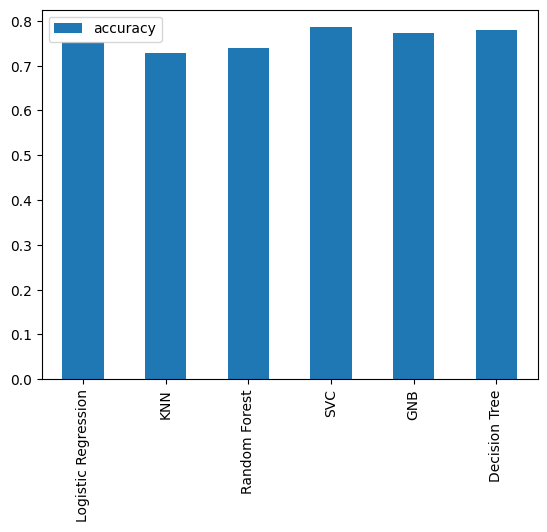

In [28]:
model_compare = pd.DataFrame(model_scores,index=["accuracy"])
model_compare.T.plot.bar()

## Tuning Logistic Regression

In [29]:
log_reg_grid = {"C":np.logspace(-4,4,20),
                "solver":["liblinear"]}

In [30]:
np.random.seed(1)

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_log_reg.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [31]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 4.281332398719396}

In [32]:
rs_log_reg.score(x_test,y_test)

0.7597402597402597

Original was 0.7532467532467533, so there is an improvement

## Tuning RandomForestClassifier()

In [33]:
rf_grid = {"n_estimators":np.arange(10,1000,50),
           "max_depth":[None,3,5,10],
           "min_samples_split":np.arange(2,20,2),
           "min_samples_leaf":np.arange(1,20,2)}

In [34]:
np.random.seed(1)

rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

rs_rf.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [35]:
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 16,
 'min_samples_leaf': 1,
 'max_depth': None}

In [36]:
rs_rf.score(x_test,y_test)

0.7402597402597403

Original was 0.7402597402597403, so there is no improvement

## Tuning KNN

In [37]:
knn_grid = {"n_neighbors":np.arange(1,31,1),
            "weights":["uniform","distance"]}

In [38]:
rs_knn = RandomizedSearchCV(KNeighborsClassifier(),
                            param_distributions=knn_grid,
                            cv=5,
                            n_iter=20,
                            verbose=True)

rs_knn.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'weights': ['uniform', 'distance']},
                   verbose=True)

In [39]:
rs_knn.best_params_

{'weights': 'distance', 'n_neighbors': 26}

In [40]:
rs_knn.score(x_test,y_test)

0.7337662337662337

Original was 0.7272727272727273 ,so there is an improvement

## Tuning SVM

In [41]:
svc_grid = {"C":[0.1,1,100,1000],
            "gamma":["scale",1,0.1,0.01,0.001],
            "kernel":['rbf']}

In [42]:
rs_svc = RandomizedSearchCV(SVC(),
                            param_distributions=svc_grid,
                            cv=5,
                            n_iter=20,
                            verbose=True)

rs_svc.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=20,
                   param_distributions={'C': [0.1, 1, 100, 1000],
                                        'gamma': ['scale', 1, 0.1, 0.01, 0.001],
                                        'kernel': ['rbf']},
                   verbose=True)

In [43]:
rs_svc.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

In [44]:
rs_svc.score(x_test,y_test)

0.7857142857142857

Original was 0.7857142857142857, so there is no improvement

## Tuning GNB

In [45]:
gnb_grid = {"var_smoothing":np.logspace(0,-9,num=100)}

In [46]:
rs_gnb = RandomizedSearchCV(GaussianNB(),
                            param_distributions=gnb_grid,
                            cv=5,
                            n_iter=20,
                            verbose=True)

rs_gnb.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=20,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.5111917...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   verbose=True)

In [47]:
rs_gnb.best_params_

{'var_smoothing': 5.336699231206313e-07}

In [48]:
rs_gnb.score(x_test,y_test)

0.7662337662337663

Original was 0.7727272727272727, hence there is a downgrade. Hence use var_smoothing as 1e-09

## Tuning Decision Tree

In [49]:
dt_grid = {"max_depth": [3, None],
           "max_features": np.arange(1,10,1),
           "min_samples_leaf": np.arange(1,10,1),
           "criterion": ["gini", "entropy"]}

In [50]:
rs_dt = RandomizedSearchCV(DecisionTreeClassifier(),
                           param_distributions=dt_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

rs_dt.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   verbose=True)

In [51]:
rs_dt.best_params_

{'min_samples_leaf': 6, 'max_features': 6, 'max_depth': 3, 'criterion': 'gini'}

In [52]:
rs_dt.score(x_test,y_test)

0.7402597402597403

Original was 0.7792207792207793 so there is a downgrade

In [53]:
scores = {'Logistic Regression': rs_log_reg.score(x_test,y_test),
          'KNN': rs_knn.score(x_test,y_test),
          'Random Forest': rs_rf.score(x_test,y_test),
          'SVC': rs_svc.score(x_test,y_test),
          'GNB': rs_gnb.score(x_test,y_test),
          'Decision Tree': rs_dt.score(x_test,y_test)}

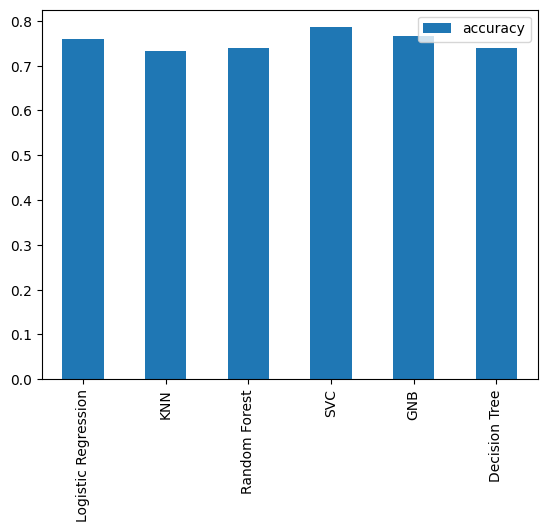

In [54]:
model_compare1 = pd.DataFrame(scores,index=["accuracy"])
model_compare1.T.plot.bar();

In [55]:
scores

{'Logistic Regression': 0.7597402597402597,
 'KNN': 0.7337662337662337,
 'Random Forest': 0.7402597402597403,
 'SVC': 0.7857142857142857,
 'GNB': 0.7662337662337663,
 'Decision Tree': 0.7402597402597403}

### The best model among these is SVC(), hence we will proceed with that

In [56]:
y_preds = rs_svc.predict(x_test)
y_preds

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=int64)

In [57]:
y_test

615    0
80     0
148    0
132    1
501    0
      ..
127    0
185    1
85     0
497    0
86     0
Name: Outcome, Length: 154, dtype: int64

In [58]:
confusion_matrix(y_test,y_preds)

array([[95,  5],
       [28, 26]], dtype=int64)

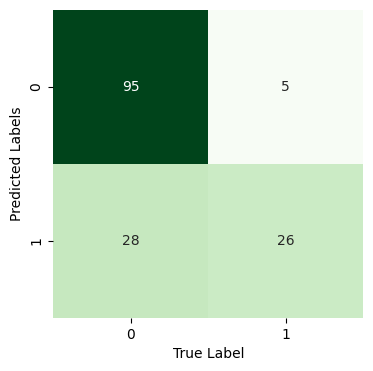

In [59]:
# Plotting confusion matrix sing seaborn

def plot_conf_matrix(y_test,y_preds):
    fig,ax = plt.subplots(figsize=(4,4))
    ax = sns.heatmap(confusion_matrix(y_test,y_preds),
                     annot=True,
                     cbar=False,
                     cmap="Greens")
    
    plt.xlabel("True Label")
    plt.ylabel("Predicted Labels")
    
plot_conf_matrix(y_test,y_preds)

In [60]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       100
           1       0.84      0.48      0.61        54

    accuracy                           0.79       154
   macro avg       0.81      0.72      0.73       154
weighted avg       0.80      0.79      0.77       154



In [61]:
rs_svc.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

In [62]:
clf = SVC(kernel='rbf',
          gamma='scale',
          C=1)

In [63]:
clf.fit(x_train,y_train)

SVC(C=1)

In [64]:
clf.score(x_test,y_test)

0.7857142857142857

## Prediction

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_test)

StandardScaler()

In [71]:
# input_data = (8,183,64,0,0,23.3,0.672,32)
input_data = (3,173,84,33,474,35.7,0.258,22)

input_data_as_numpy_array = np.asarray(input_data)
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

std_data = scaler.transform(input_data_reshaped)

prediction = clf.predict(std_data)

if (prediction[0] == 0):
  print('No Diabetes')
else:
  print('Diabetes')

No Diabetes


In [67]:
import pickle
pickle.dump(clf, open('diabetes_model.sav', 'wb'))
model = pickle.load(open('diabetes_model.sav', 'rb'))